In [2]:
import pandas as pd
import polars as pl
from functools import partial
from itertools import tee, chain
import re
import json
from collections import Counter, defaultdict
from itertools import islice
from typing import Generator, Any
from pathlib import Path
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
from Bio import SeqIO
from Bio import SeqRecord
from sklearn.metrics import DistanceMetric

In [3]:
def get_set_count(df: pd.DataFrame, set_name: str) -> pd.DataFrame:
    print(df.groupby(set_name).size().sort_values(ascending=False))
    return df

get_set_count_conjunto = partial(get_set_count, set_name='Conjunto')

def filter_checkm_table(fname: str) -> pd.DataFrame:
    
    wanted_keys = {'Completeness', 'Contamination', 'GC', 'GC std'}
    
    all_data = defaultdict(list)
    
    with open(fname, 'r') as f:
        for line in f.read().splitlines():
            genome, data = line.split('\t')
            all_data['genome_id'].append(genome)
            for k, v in json.loads(data.replace("'", '"')).items():
                if k in wanted_keys:
                    all_data[k].append(v)
    
    return pd.DataFrame.from_dict(all_data)

def shead(df: pd.DataFrame):
    print('rows: {}\ncols: {}'.format(*df.shape))
    return df.head()

pd.DataFrame.shead = shead


def log_df(df: pd.DataFrame, message: str, *args: str) -> pd.DataFrame:
    print(message, *args)
    return df


In [4]:
kleborate_table = '/home/hugo.avila/Projects/reparoma/results/kleborate/kleborate_summary.tbl'
checkm_genus_table = '/home/hugo.avila/Projects/reparoma/results/checkm/Klebsiella_genus/storage/bin_stats_ext.tsv'
checkm_pneumoniae_table = '/home/hugo.avila/Projects/reparoma/results/checkm/Klebsiella_pneumoniae/storage/bin_stats_ext.tsv'
checkm_oxytoca_table = '/home/hugo.avila/Projects/reparoma/results/checkm/Klebsiella_oxytoca/storage/bin_stats_ext.tsv'

In [6]:
checkm_tables = [checkm_genus_table, checkm_pneumoniae_table, checkm_oxytoca_table]

checkm_df = []

for table in map(Path, checkm_tables):
    checkm_df.append(filter_checkm_table(table).assign(gene_set=table.parents[1].name.replace('_', ' ')))

checkm_df = pd.concat(checkm_df, ignore_index=True)

checkm_df.head()

,genome_id,Completeness,Contamination,GC,GC std,gene_set
0,GCF_000613225.1_SB30_PRJEB5159,99.688913,0.350596,0.582036,0.028063,Klebsiella genus
1,GCF_000612905.1_KPSB59_PRJEB5158,99.406346,1.930875,0.578557,0.048806,Klebsiella genus
2,GCF_000383335.1_ASM38333v1,95.419569,1.383145,0.550775,0.000000,Klebsiella genus
3,GCF_000534135.1_Ente_aero_UCI_45_V1,94.605393,1.393963,0.548809,0.039504,Klebsiella genus
4,GCF_000492795.1_Kleb_pneu_MGH_44_V1,99.688913,0.810527,0.577385,0.056401,Klebsiella genus


In [7]:
kleborate_df = (
    pd.read_csv(kleborate_table, sep='|')
    # get only genomes with specie assign as "strong"
    .loc[lambda df_: df_.species_match.eq('strong')]
    # Group by Kleborate designeted species and drop species with less than 30 members
    .assign(
    _species=lambda df_: df_.species.str.split(' ').str[:2].apply(' '.join)
    )
    .groupby('_species')
    .filter(lambda df_: df_.shape[0] >= 30)
    # Removing genomes N50 < 10_000
    .loc[lambda df_: ~df_.N50.lt(10_000)]
    # Removing genomes with more than 1% ambiguos bases
    .assign(_ambiguous_bases = lambda df_: df_.ambiguous_bases.apply( lambda x: int(capture[0]) if (capture := re.findall('\d+', x)) else 0 ) )
    .loc[lambda df_: (df_._ambiguous_bases * 100 / df_.total_size) < 1  ]
    .pipe(get_set_count_conjunto)    
)

kleborate_df.head()

Conjunto
refseq    14857
nguyen     1657
dtype: int64


,strain,species,species_match,contig_count,N50,largest_contig,total_size,ambiguous_bases,QC_warnings,ST,Conjunto,_species,_ambiguous_bases
0,GCF_000009885.1_ASM988v1,Klebsiella pneumoniae,strong,2,5248520,5248520,5472672,no,-,ST23,refseq,Klebsiella pneumoniae,0
1,GCF_000019565.1_ASM1956v1,Klebsiella variicola subsp. variicola,strong,3,5641239,5641239,5920257,no,-,ST146,refseq,Klebsiella variicola,0
2,GCF_000025465.1_ASM2546v1,Klebsiella variicola subsp. variicola,strong,1,5458505,5458505,5458505,no,-,ST1220,refseq,Klebsiella variicola,0
3,GCF_000163075.1_ASM16307v1,Klebsiella variicola subsp. variicola,strong,19,1084691,1875766,5459739,yes (42263),ambiguous_bases,ST848,refseq,Klebsiella variicola,42263
6,GCF_000215745.1_ASM21574v1,Klebsiella aerogenes,strong,1,5280350,5280350,5280350,yes (1),ambiguous_bases,NaN,refseq,Klebsiella aerogenes,1


In [11]:
kleborate_df._species.value_counts()

Klebsiella pneumoniae         14129
Klebsiella quasipneumoniae      684
Klebsiella variicola            584
Klebsiella michiganensis        347
Klebsiella aerogenes            333
Klebsiella oxytoca              230
Klebsiella grimontii            168
Klebsiella pasteurii             39
Name: _species, dtype: int64

In [15]:
checkm_df.head()

,genome_id,Completeness,Contamination,GC,GC std,gene_set
0,GCF_000613225.1_SB30_PRJEB5159,99.688913,0.350596,0.582036,0.028063,Klebsiella genus
1,GCF_000612905.1_KPSB59_PRJEB5158,99.406346,1.930875,0.578557,0.048806,Klebsiella genus
2,GCF_000383335.1_ASM38333v1,95.419569,1.383145,0.550775,0.000000,Klebsiella genus
3,GCF_000534135.1_Ente_aero_UCI_45_V1,94.605393,1.393963,0.548809,0.039504,Klebsiella genus
4,GCF_000492795.1_Kleb_pneu_MGH_44_V1,99.688913,0.810527,0.577385,0.056401,Klebsiella genus


In [26]:
# Filtering with completeness and contamination 

checkm_has_gene_set = (
    kleborate_df
    .merge(
        checkm_df,
        left_on=['strain', '_species'],
        right_on=['genome_id', 'gene_set'],
        validate='1:1'
    )
)

checkm_dont_have_gene_set = (
    kleborate_df
    .loc[lambda df_: ~df_.strain.isin(checkm_has_gene_set.strain)]
    .merge(
        checkm_df.loc[lambda df_: df_.gene_set.eq('Klebsiella genus')],
        left_on='strain',
        right_on='genome_id',
        validate='1:1'
    )
)


kleborate_and_checkm_df = (
    pd.concat([checkm_has_gene_set, checkm_dont_have_gene_set], ignore_index=True)
    .loc[lambda df_: (df_.Completeness >= 98) & (df_.Contamination <= 4) ]
    .pipe(get_set_count_conjunto)
)


kleborate_and_checkm_df.head(5)

Conjunto
refseq    14144
nguyen     1599
dtype: int64


,strain,species,species_match,contig_count,N50,largest_contig,total_size,ambiguous_bases,QC_warnings,ST,Conjunto,_species,_ambiguous_bases,genome_id,Completeness,Contamination,GC,GC std,gene_set
0,GCF_000009885.1_ASM988v1,Klebsiella pneumoniae,strong,2,5248520,5248520,5472672,no,-,ST23,refseq,Klebsiella pneumoniae,0,GCF_000009885.1_ASM988v1,99.671286,0.214289,0.573692,0.050965,Klebsiella pneumoniae
1,GCF_000219945.1_ASM21994v2,Klebsiella pneumoniae,strong,118,141130,527367,5534249,yes (16),ambiguous_bases,ST134,refseq,Klebsiella pneumoniae,16,GCF_000219945.1_ASM21994v2,99.040303,1.015858,0.571853,0.064783,Klebsiella pneumoniae
2,GCF_000219965.1_ASM21996v2,Klebsiella pneumoniae,strong,116,161835,414017,5535020,yes (3),ambiguous_bases,ST133,refseq,Klebsiella pneumoniae,3,GCF_000219965.1_ASM21996v2,99.714802,1.459627,0.573257,0.043171,Klebsiella pneumoniae
3,GCF_000220485.1_ASM22048v1,Klebsiella pneumoniae,strong,2,5259571,5259571,5462423,yes (7),ambiguous_bases,ST375,refseq,Klebsiella pneumoniae,7,GCF_000220485.1_ASM22048v1,99.714802,0.189423,0.572775,0.050298,Klebsiella pneumoniae
4,GCF_000238715.1_Klebsiella_sp_4_1_44FAA_V1,Klebsiella pneumoniae,strong,78,501071,1096638,5525042,yes (46173),ambiguous_bases,ST1221,refseq,Klebsiella pneumoniae,46173,GCF_000238715.1_Klebsiella_sp_4_1_44FAA_V1,98.175002,0.721388,0.571147,0.052406,Klebsiella pneumoniae


In [14]:
kleborate_and_checkm_df._species.value_counts()

Klebsiella pneumoniae         13731
Klebsiella quasipneumoniae      675
Klebsiella variicola            573
Klebsiella michiganensis        343
Klebsiella oxytoca              216
Klebsiella grimontii            166
Klebsiella pasteurii             39
Name: _species, dtype: int64

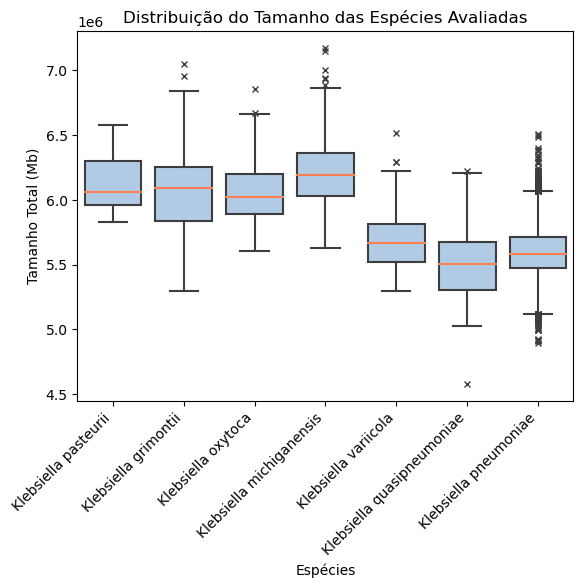

In [9]:
# Removing lenght outliers

## Getting lenght whiskers (to remove the outliers)
lenght_whiskers = (
    kleborate_and_checkm_df
    .groupby('_species')
    ['total_size']
    .agg(
        lower_whisker = lambda x: boxplot_stats(x)[0]['whislo'],
        higher_whisker = lambda x: boxplot_stats(x)[0]['whishi']
    )
)

## Plotting lenght 
lenght_boxplot = sns.boxplot(
    data=kleborate_and_checkm_df,
    x='_species',
    y='total_size',
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
    order=kleborate_and_checkm_df.groupby('_species').size().sort_values().index
)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Espécies")
plt.ylabel("Tamanho Total (Mb)")
plt.title("Distribuição do Tamanho das Espécies Avaliadas")


def my_save_fig(fig, output_prefix, extension='png',):
    (
        fig
        .figure
        .savefig(
            f'{output_prefix}.{extension}',
            bbox_inches='tight',
            dpi=600,
            facecolor='white',
            edgecolor='black'
        )
    )
    

output_prefix = '/home/hugo.avila/Projects/reparoma/results/figures/boxplot_distribuicao_de_tamanhos'
my_save_fig(lenght_boxplot, output_prefix, 'svg')
my_save_fig(lenght_boxplot, output_prefix)

In [10]:
kleborate_and_checkm_removed_outliers_df = (
    kleborate_and_checkm_df
    .groupby('_species', as_index=False)
    .apply(
        lambda df_: (
            df_.loc[
                lambda df__: (df__.total_size > lenght_whiskers.loc[df_.name].lower_whisker) & (df__.total_size < lenght_whiskers.loc[df_.name].higher_whisker)
            ]
        )
    )
    .reset_index(drop=True)
    .pipe(get_set_count_conjunto)
)

kleborate_and_checkm_removed_outliers_df.head()

Conjunto
refseq    13966
nguyen     1592
dtype: int64


,strain,species,species_match,contig_count,N50,largest_contig,total_size,ambiguous_bases,QC_warnings,ST,Conjunto,_species,_ambiguous_bases,genome_id,Completeness,Contamination,GC,GC std,gene_set
0,GCF_000427015.1_kleoxysa2,Klebsiella grimontii,strong,72,507479,1009176,5762085,no,-,NaN,refseq,Klebsiella grimontii,0,GCF_000427015.1_kleoxysa2,99.896232,1.392382,0.558845,0.076685,Klebsiella genus
1,GCF_001052235.1_ASM105223v1,Klebsiella grimontii,strong,256,67275,136357,6247497,yes (411),ambiguous_bases,NaN,refseq,Klebsiella grimontii,411,GCF_001052235.1_ASM105223v1,99.896232,1.027599,0.554277,0.057359,Klebsiella genus
2,GCF_001052825.1_ASM105282v1,Klebsiella grimontii,strong,164,128131,349613,6248470,yes (309),ambiguous_bases,NaN,refseq,Klebsiella grimontii,309,GCF_001052825.1_ASM105282v1,99.896232,0.848001,0.555844,0.045088,Klebsiella genus
3,GCF_001053665.1_ASM105366v1,Klebsiella grimontii,strong,351,47832,155074,6187924,yes (13),ambiguous_bases,NaN,refseq,Klebsiella grimontii,13,GCF_001053665.1_ASM105366v1,99.896232,0.946523,0.555974,0.049265,Klebsiella genus
4,GCF_001054995.1_ASM105499v1,Klebsiella grimontii,strong,220,81971,207191,6006839,yes (410),ambiguous_bases,NaN,refseq,Klebsiella grimontii,410,GCF_001054995.1_ASM105499v1,99.752554,0.972978,0.556954,0.048169,Klebsiella genus


In [12]:
kleborate_and_checkm_removed_outliers_df._species.value_counts()

Klebsiella pneumoniae         13573
Klebsiella quasipneumoniae      671
Klebsiella variicola            568
Klebsiella michiganensis        335
Klebsiella oxytoca              212
Klebsiella grimontii            162
Klebsiella pasteurii             37
Name: _species, dtype: int64

In [10]:
def get_coregenome_threshold(ngenomes: int, threshold: int | float = 0.95) -> int:
    return int(ngenomes * threshold)

def read_fmt_4(fn: str) -> pd.DataFrame:
    with open(fn, 'r') as f:
        lines = map(str.strip, filter(lambda line: line[:-1], f))
        cols = next(lines).split('\t')[1:]
        recs = filter(lambda rec: not rec.startswith('Node'), lines)
        recs = map(lambda x: ((rec := x.split('\t'))[0], *tuple(map(int, rec[1:]))), recs)
        return pd.DataFrame(data=recs , columns=('genomes', *cols)).set_index('genomes')
        
# Reading checkM markers pres abs file
fmt_4_df = (
    read_fmt_4('/home/hugo.avila/Projects/reparoma/results/checkm/Klebsiella_pneumoniae/marker_genes_fmt_4.tsv')
    # Removing filtered genomes
    .loc[lambda df_: df_.index.isin(set(kleborate_and_checkm_removed_outliers_df.strain.values))]
)

fmt_4_df.head()

,PF12168.3,PF00687.16,PF09932.4,TIGR01966,PF07356.7,PF00520.26,PF02548.10,PF02565.10,PF08029.6,PF13286.1,...,TIGR02160,TIGR01364,PF08223.6,TIGR00044,TIGR03703,PF03802.9,PF14450.1,TIGR02967,PF00281.14,PF04560.15
genomes,,,,,,,,,,,,,,,,,,,,,
573.12858,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
573.12859,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
573.12860,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
573.12861,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
573.12862,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


{'genomes': 15558, 'markers': 283}


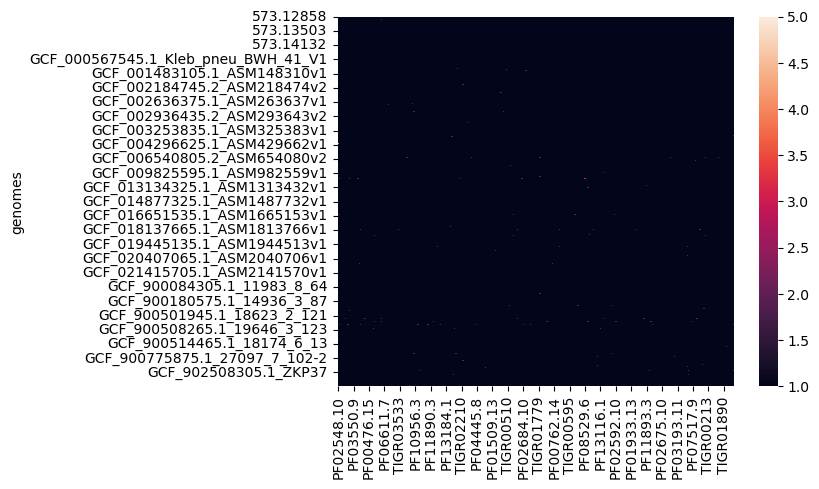

In [426]:
# markers above threshold 
coregenome_threshold = get_coregenome_threshold(fmt_4_df.index.shape[0], threshold=1) # 1 is 100% of the genomes

allowed_duplication_perc = .005

pres_abs_mask = (
    fmt_4_df
    .applymap(bool)
    .sum(axis=0)
    .loc[lambda series_: series_ >= coregenome_threshold]
    .index
    .values
)

positive_markers = (
    fmt_4_df
    # coregenome threshold
    .loc[:, pres_abs_mask]
#     # remove extremaly duplicated genes
    .pipe(
        lambda df_: df_.loc[:, df_.gt(1).sum().le(int(df_.shape[0] * allowed_duplication_perc))]
    )
)

positive_markers_set = set(positive_markers.columns)

print(dict(zip(('genomes', 'markers'), positive_markers.shape)))

fig = sns.heatmap(positive_markers)

In [590]:
# get duplicated markers    
duplicated_markers = (
    positive_markers
    .stack()
    .loc[lambda series_: series_.gt(1)]
    .rename_axis(cols := ['genomes', 'markers'])
    .reset_index()
    .drop([0], axis=1)
)



duplicated_markers.shead()

rows: 3924
cols: 2


,genomes,markers
0,573.12906,PF09334.6
1,573.12921,PF03819.12
2,573.12939,PF08275.6
3,573.12948,PF08478.5
4,573.12954,PF02548.10


In [453]:
# def info_to_dict(info_string: str) -> dict:
#     return dict(map(lambda x: x.split('='), info_string.split(';')))

# def read_fmt_9(fn: str) -> Generator[tuple[str], None, None]:
#     with open(fn, 'r') as f:
#         lines = tee(map(str.strip, f), 2)
#         headers = map(lambda x: x.strip('>'), filter(lambda x: x.startswith('>'), lines[0]))
#         records = filter(lambda x: not x.startswith('>'), lines[1])
#         for header in headers:
#             genome_id, contig_id, locus_tag_info, marker_info = header.split()
#             locus_tag_id = info_to_dict(locus_tag_info)['geneId']
#             marker_id = info_to_dict(marker_info)['marker']
#             yield genome_id, marker_id, next(records)
            
# def filter_garbage_records(df: pd.DataFrame) -> pd.DataFrame:
#     ngenomes = len(df.genome_id.unique())
#     return df.groupby('marker_id').filter(lambda gdf_: gdf_.shape[0] == ngenomes and len(gdf_.genome_id.unique()) == ngenomes )


# data = filter(lambda x: x[1] in positive_markers_set, read_fmt_9('/home/hugo.avila/Projects/reparoma/results/checkm/Klebsiella_pneumoniae/Klebsiella_pneumoniae.faa'))

# temp_ = (
#     pd.DataFrame(
#         data=data,
#         columns=['genome_id', 'marker_id', 'sequence']
#     )
#     .pipe(filter_garbage_records)
# )

# temp_.head()

,genome_id,marker_id,sequence


In [19]:
def parse_marker_gene_stats(fn: str):
    with open(fn, 'r') as f:
        for i in map(str.strip, f):
            genome_id, rec = i.split('\t')
            rec = { k: [tuple(v.keys())] for k, v in json.loads(rec.replace("'", '"')).items() }
            yield (
                pd.DataFrame.from_dict(data=rec, columns=[genome_id], orient='index')
                .explode(genome_id)
                .unstack()
                .reset_index()
            )
    
def read_fasta(fn: str) -> Generator[tuple[str], None, None]:
    for i in SeqIO.parse(fn, 'fasta'):
        yield (i.id.split()[0], str(i.seq))
            
def head(generator: Generator, nitems: int = 5) -> Generator[Any, None, None]:
    for i in islice(generator, 0, nitems):
        yield i

# Get only first ngenomes
# ngenomes = 5

data = parse_marker_gene_stats('/home/hugo.avila/Projects/reparoma/results/checkm/Klebsiella_pneumoniae/storage/marker_gene_stats.tsv')

# # Get only positive markers
# data = map(lambda df_: df_.loc[lambda df__: df__.isin(positive_markers_set)].reset_index(), data)

# concatenate all tables 
markers_locus_tags_df = (
    pd.concat(data, ignore_index=True)
    .rename(columns={'level_0' : 'genomes', 'level_1': 'locus_tags', 0: 'markers'})
    .astype({'genomes': 'category', 'markers': 'category'})
)

markers_locus_tags_df.head()

,genomes,locus_tags,markers
0,573.12863,2Xwby1f2_28_54,TIGR00856
1,573.12863,2Xwby1f2_1_248,TIGR02415
2,573.12863,2Xwby1f2_1_137,TIGR02423
3,573.12863,2Xwby1f2_13_65,TIGR03420
4,573.12863,2Xwby1f2_5_210,TIGR02797


In [652]:
# CREATING MULTIFASTAS FOR ALIGNMENT 
def extract_records(genome, fn, locus_set):
    return (
        pd.DataFrame(data=tuple(filter(lambda x: x[0] in locus_set, read_fasta(fn))), columns=['locus_tags', 'records'])
        .assign(genomes = genome)
    )

def concat_from_values(x):
    return pd.concat(x.values, ignore_index=True)

pd.Series.concat_from_values = concat_from_values

def df_to_fasta(df: pd.DataFrame, output_dir: str) -> pd.DataFrame:
    with open(f'{output_dir}/{df.name}.faa', 'w') as f:
        f.write(
            ''.join(
                df
                .assign(fasta_records = lambda df_: '>' + df_.genomes + '\n' + df_.records + '\n')
                .fasta_records
            )
        )
    return df
        


output_dir_multifastas = '/home/hugo.avila/Projects/reparoma/results/checkm_tree/Klebsiella_pneumoniae/fastas'

(
    # Get only genome names from markers
    markers_locus_tags_df[['genomes']]
    .drop_duplicates()
    .pipe(log_df,  message='All genome_id retrived !')
    # Get the paths of the genome's faas
    .assign(fn = lambda df_: '/home/hugo.avila/Projects/reparoma/results/checkm/Klebsiella_pneumoniae/bins/' + df_.genomes + '/genes.faa')
    .pipe(log_df,  message='All fasta paths retrived !')
    # Get the individual locus_tags of all genomes
    .merge(
        markers_locus_tags_df[['genomes', 'locus_tags']].groupby('genomes').agg(set),
        on='genomes'
    )
    .pipe(log_df,  message='Added locus_tags ids !')
    # Extract only the wanted locus_tags from the genomes
    .assign(records = lambda df_: df_.apply(lambda x: extract_records(x.genomes, x.fn, x.locus_tags), axis='columns'))
    .pipe(log_df,  message='Finished extracting locus_tags from the genomes !')
    .records
    # Create a new dataframe with the the extracted fastas
    .concat_from_values()
    .pipe(log_df,  message='All records concatenated !')
    # Readd the marker information
    .merge(
        markers_locus_tags_df[['markers', 'locus_tags']],
        on='locus_tags',
    )
    .pipe(log_df,  message='Aded markers ids !')
    # remove duplicated markers
    .groupby(['genomes', 'markers'])
    .filter(lambda df_: df_.shape[0] == 1)
    .pipe(log_df,  message='Removed all duplicated markers !')
    # Group fasta records by marker
    .groupby('markers', group_keys=False)
    # Write markers to multi fasta files for aligment
    .apply(partial(df_to_fasta, output_dir=output_dir_multifastas))
    .pipe(log_df,  message='Finished writting all files !')
    .shead()
)

All genome_id retrived !
All fasta paths retrived !
Added locus_tags ids !
Finished extracting locus_tags from the genomes !
All records concatenated !
Aded markers ids !
Removed all duplicated markers !
Finished writting all files !
rows: 4727541
cols: 4


,locus_tags,records,genomes,markers
0,2Xwby1f2_2_47,MRNRTFADLDRVVALGGGHGLGRVMSSLSSLGSRLTGIVTTTDNGG...,573.12863,PF01933.13
1,2Xwby1f2_2_48,MTASPVFGKVYMASQLTDAFARKFYYLRLSITDVCNFRCTYCLPNG...,573.12863,PF06463.8
2,2Xwby1f2_2_50,MSQLTHINAAGEAHMVDVSGKAETVREARAEAYVEMQATTLAMIID...,573.12863,PF01967.16
3,2Xwby1f2_2_149,MFSGLFIILLPLVVGYLLPLRHSSALKLINRMLSWIVYVILFFMGI...,573.12863,PF03956.8
4,2Xwby1f2_2_176,MAQVYNFSSGPAMLPAEVLKLAQQELCDWHGLGTSVMEISHRGKEF...,573.12863,TIGR01364


In [710]:
# RUN THIS AFFTER Running mafft

# Command line:
# mafft \
#     --thread $number_of_threads \
#     --auto \
#     $input_fasta > $output_aln 


def fasta_to_matrix(fn: str) -> pd.DataFrame:
    with open(fn, 'r') as f:
        recs = map(lambda x: (x.id, *tuple(x.seq)), SeqIO.parse(f, 'fasta'))
        return pd.DataFrame(data=recs, dtype='category').set_index(0).rename_axis('genomes')

def add_col_level(df: pd.DataFrame, level: str) -> pd.DataFrame:
    df.columns = pd.MultiIndex.from_product([[level], df.columns])
    return df

def remove_empty_sites(df: pd.DataFrame, threshold: float = 1.0) -> pd.DataFrame:
    return (
        df.loc[:, lambda df_: df_.agg(lambda series_: series_.value_counts().to_dict().get('-', 0)).lt(int(df_.shape[0]) * threshold)]
    )

def remove_equal_sites(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df.loc[:, lambda df_: ~df_.agg(lambda series_: series_.cat.categories.size).eq(1)]
    )

def get_name_of_marker(df: pd.DataFrame) -> pd.DataFrame:
    print(df.columns.get_level_values(0).unique()[0])
    return df

# def prepare_record_to_concat(fn: str) -> pd.DataFrame:
#         return (
#             fasta_to_matrix(fn)
#             .pipe(add_col_level, level=fn.stem)
#             .pipe(remove_empty_sites, threshold=.9)
#             .pipe(remove_equal_sites)
#             .pipe(get_name_of_marker)
#         )


def fill_empty_records(df: pd.DataFrame, genome_lables: set) -> pd.DataFrame:
    # Genome sets 
    present = set(df.index.values)
    absense = genome_lables - present
    
    # Check if all genes are present
    if not absense:
        return df
    
    # Create some filling
    return (
        pd.concat(
            (
                # Original df
                df,
                # Filling df
                pd.DataFrame(data=[['-'] * df.shape[1] ] * len(absense), index=tuple(absense), columns=df.columns)
            ),
        )
    )


def write_recs_to_file(series: pd.Series, fn: str) -> None:
    print('Writting fasta ...')
    with open(fn, 'w') as f:
        f.write(''.join(series.values))
    print('Finished Writting !')
    
multi_align_output = '/home/hugo.avila/Projects/reparoma/results/checkm_tree/Klebsiella_pneumoniae/alns/'

# Convert fasta files to matrix 
data = map(
    lambda fn: add_col_level(fasta_to_matrix(fn), level=str(fn.name).strip('.aln.faa')),
    Path(multi_align_output).glob('*.faa')
)

# Get only records from wanted genomes (only the remaining after qc)
clean_genome_set = set(positive_markers.index)
data = map(lambda df_: df_.loc[df_.index.to_series().isin(clean_genome_set).values], data)

# Apply filters (remove sites that have equal values and/or are empty (.9 theshold))
empty_threshold = .9
data = map(
    lambda df_: (
        df_
        .pipe(remove_empty_sites, threshold=empty_threshold)
        .pipe(remove_equal_sites)
        .pipe(get_name_of_marker)
    ),
    data
)

print('Finished filtering')


# Fill missing genes 
data = map(
    lambda df_: fill_empty_records(df_, clean_genome_set),
    data
)

print('Finished filling missing genes')

# marge all records and write then to a file 
(
    pd.concat(data, axis='columns')
    .pipe(log_df, message='Finished concatenation')
    .agg(lambda series_: f'>{series_.name}\n{"".join(series_.values)}\n', axis='columns')
    .pipe(log_df, message='Finished fasta record creation.')
    .pipe(write_recs_to_file, fn=multi_align_output + '/concatenated.aln.faa')
)

print('Finished fasta file creation.')

Finished filtering
Finished filling missing genes
TIGR01854
PF04333.8
PF06325.8
PF02547.10
PF12633.2
PF01783.18
TIGR01072
PF00764.14
TIGR00668
TIGR02437
PF09382.5
PF02749.11
PF00507.14
TIGR02210
PF01195.14
PF02639.9
PF05697.8
TIGR00838
TIGR02651
TIGR01410
TIGR01770
PF03923.8
PF12327.3
PF11741.3
PF00013.24
TIGR00966
PF02551.10
PF01256.12
PF01794.14
PF01257.14
PF00745.15
PF12724.2
TIGR02193
PF13793.1
PF01255.14
TIGR00751
PF02618.11
PF13484.1
PF03601.9
PF02675.10
PF02130.12
PF08364.6
PF04613.9
PF02367.12
PF00091.20
PF04378.8
PF00709.16
TIGR01305
PF07254.7
TIGR00519
PF08676.6
PF00471.15
PF09849.4
PF07743.8
PF04760.10
PF04546.8
PF03938.9
TIGR02007
PF08478.5
PF04445.8
PF06723.8
PF00762.14
PF04228.8
PF03668.10
PF13742.1
PF06224.7
TIGR02197
PF02699.10
PF06196.7
PF01043.15
PF04358.8
PF02410.10
PF02666.10
PF00476.15
PF02548.10
PF04336.7
PF04413.11
PF03602.10
TIGR01087
PF07517.9
PF06574.7
TIGR00759
TIGR00688
PF06899.6
PF13464.1
PF08275.6
TIGR00595
PF09223.6
PF02670.11
PF06463.8
TIGR00875
PF02646.

In [885]:
# Single species trees: CREATING MULTIFASTAS

def format_marker_gene_stats(fn: str) -> pd.DataFrame:
    # concatenate all tables 
    return (
        pd.concat(
             map(
                 lambda df_: df_.reset_index(),
                 parse_marker_gene_stats(fn)
             ),
            ignore_index=True
        )
        .rename(columns={'level_0' : 'genomes', 'level_1': 'locus_tags', 0: 'markers'})
    )

def get_duplicated_markers(df: pd.DataFrame):
    return set(
        df
        .stack()
        .loc[lambda series_: series_.gt(1)]
        .rename_axis(cols := ['genomes', 'markers'])
        .reset_index()
        .drop([0], axis=1)
        .index
        .values
    )

def select_markers(
    marker_df: str,
    fig_output: str,
    coregenome_limit: float = .95,
    allowed_duplication_perc: float = .005,
):
    
    coregenome_threshold = get_coregenome_threshold(marker_df.index.shape[0], threshold=coregenome_limit) # 1 is 100% of the genomes
    
    
    positive_markers = (
        marker_df
        # Get coregenome genes
        .loc[:, lambda df_: df_.gt(0).sum().ge(coregenome_threshold)]
        # remove extremaly duplicated genes
        .pipe(
            lambda df_: df_.loc[:, df_.gt(1).sum().le(int(df_.shape[0] * allowed_duplication_perc))]
        )
    )
    
    fig = sns.heatmap(positive_markers)
    fig.figure.savefig(fig_output)
    plt.close()
    
    positive_markers_set = set(positive_markers.columns)
    print(dict(zip(('genomes', 'markers'), positive_markers.shape)))
    
    return positive_markers




##########################
# markers_locus_tags_df = format_marker_gene_stats('/home/hugo.avila/Projects/reparoma/results/checkm/Klebsiella_pneumoniae/storage/marker_gene_stats.tsv')
##########################


single_species_trees_outdir = Path('/home/hugo.avila/Projects/reparoma/results/single_species_trees')

species = kleborate_and_checkm_removed_outliers_df._species.value_counts().sort_values().index.values
species_and_genome_ids = kleborate_and_checkm_removed_outliers_df[['strain', '_species']].rename(columns={'_species' : 'species'})

for specie in species:
    print('STARTED: ', specie)
    
    (specie_output_dir := (single_species_trees_outdir / specie.replace(' ', '_'))).mkdir(parents=True, exist_ok=True)
    
    for _dir in ['trees', 'fastas']:
        (specie_output_dir / _dir).mkdir(parents=True, exist_ok=True)
    
    only_wanted_species_genomes = (
        fmt_4_df
        .loc[lambda df_: species_and_genome_ids.loc[lambda df_: df_.species.eq(specie)].strain.values ]
    )
    

    positive_markers = select_markers(
        only_wanted_species_genomes,
        fig_output=specie_output_dir / 'copy_count_heatmap.png'
    )
    
    duplicated_markers = get_duplicated_markers(positive_markers)
    
    (
        # Get only genome names from markers
        only_wanted_species_genomes.index.to_series().to_frame().reset_index(drop=True)
        # Add genome path
        .assign(fn = lambda df_: '/home/hugo.avila/Projects/reparoma/results/checkm/Klebsiella_pneumoniae/bins/' + df_.genomes + '/genes.faa')
        .merge(
            (
                markers_locus_tags_df
                .loc[lambda df_: df_.genomes.isin(only_wanted_species_genomes.index), ['genomes', 'locus_tags']]
                .groupby('genomes')
                .agg(set)
            ),
            on='genomes'
        )
        .assign(records = lambda df_: df_.apply(lambda x: extract_records(x.genomes, x.fn, x.locus_tags), axis='columns'))
        .pipe(log_df,  message='Finished extracting locus_tags from the genomes !')
        .records
        # Create a new dataframe with the the extracted fastas
        .concat_from_values()
        .pipe(log_df,  message='All records concatenated !')
        # Readd the marker information
        .merge(
            markers_locus_tags_df[['markers', 'locus_tags']],
            on='locus_tags',
        )
        .pipe(log_df,  message='Added markers ids !')
        # remove duplicated markers
        .groupby(['genomes', 'markers'])
        .filter(lambda df_: df_.shape[0] == 1)
        .pipe(log_df,  message='Removed all duplicated markers !')
        # Group fasta records by marker
        .groupby('markers', group_keys=False)
        # Write markers to multi fasta files for aligment
        .apply(partial(df_to_fasta, output_dir=specie_output_dir / 'fastas'))
        .pipe(log_df,  message='Finished writting all files !')
    )
    print('ENDED: ', specie)

STARTED:  Klebsiella pasteurii
{'genomes': 37, 'markers': 1360}
Finished extracting locus_tags from the genomes !
All records concatenated !
Added markers ids !
Removed all duplicated markers !
Finished writting all files !
ENDED:  Klebsiella pasteurii
STARTED:  Klebsiella grimontii
{'genomes': 162, 'markers': 1180}
Finished extracting locus_tags from the genomes !
All records concatenated !
Added markers ids !
Removed all duplicated markers !
Finished writting all files !
ENDED:  Klebsiella grimontii
STARTED:  Klebsiella oxytoca
{'genomes': 212, 'markers': 1342}
Finished extracting locus_tags from the genomes !
All records concatenated !
Added markers ids !
Removed all duplicated markers !
Finished writting all files !
ENDED:  Klebsiella oxytoca
STARTED:  Klebsiella michiganensis
{'genomes': 335, 'markers': 1239}
Finished extracting locus_tags from the genomes !
All records concatenated !
Added markers ids !
Removed all duplicated markers !
Finished writting all files !
ENDED:  Klebsi

In [870]:
markers_locus_tags_df.head(.loc[lambda df_: df, ['genomes', 'locus_tags']][].groupby('genomes').agg(set)

,genomes,locus_tags,markers
0,573.12863,2Xwby1f2_13_93,TIGR00048
1,573.12863,2Xwby1f2_11_89,TIGR00214
2,573.12863,2Xwby1f2_20_2,TIGR01779
3,573.12863,2Xwby1f2_3_197,TIGR01890
4,573.12863,2Xwby1f2_28_31,PF09115.5


In [877]:
def df_to_fasta(df: pd.DataFrame, output_dir: str) -> pd.DataFrame:
    with open(f'{output_dir}/{df.name}.faa', 'w') as f:
        f.write(
            ''.join(
                df
                .assign(fasta_records = lambda df_: '>' + df_.genomes + '\n' + df_.records + '\n')
                .fasta_records
            )
        )
    return df

573.12863  2Xwby1f2_28_54    TIGR00856
           2Xwby1f2_1_248    TIGR02415
           2Xwby1f2_1_137    TIGR02423
           2Xwby1f2_13_65    TIGR03420
           2Xwby1f2_5_210    TIGR02797
dtype: object

In [883]:
# Convert fasta files to matrix 
data = map(
    lambda fn: add_col_level(fasta_to_matrix(fn), level=str(fn.name).strip('.aln.faa')),
    Path(multi_align_output).glob('*.faa')
)

# Get only records from wanted genomes (only the remaining after qc)
clean_genome_set = set(positive_markers.index)
data = map(lambda df_: df_.loc[df_.index.to_series().isin(clean_genome_set).values], data)

# Apply filters (remove sites that have equal values and/or are empty (.9 theshold))
empty_threshold = .9
data = map(
    lambda df_: (
        df_
        .pipe(remove_empty_sites, threshold=empty_threshold)
        .pipe(remove_equal_sites)
        .pipe(get_name_of_marker)
    ),
    data
)


0        148
1         66
2        119
3        328
4        328
        ... 
60189    343
60190    321
60191    321
60192    321
60193    317
Name: records, Length: 55257, dtype: int64

In [20]:
class FilterAln():
    def __init__(self, aln_fn: str, cscore_fn: str) -> None:
        self.aln_fn = Path(aln_fn)
        self.cscore_fn = Path(cscore_fn)
        
        
    def aln_to_df(self) -> pd.DataFrame:
        with open(self.aln_fn, 'r') as f:
            recs = map(lambda x: (x.id, *tuple(x.seq)), SeqIO.parse(f, 'fasta'))
            df = pd.DataFrame(data=recs, dtype='category').set_index(0).rename_axis('genomes')
            df.columns = pd.MultiIndex.from_product([[self.aln_fn.stem], df.columns])
            return df
    
    def cscore_to_df(self) -> pd.DataFrame:
        return (
            pd.read_csv(self.cscore_fn, index_col='msa_pos', dtype={'Ci': 'float'})
        )
    
    def filter_aln(self) -> pd.DataFrame:
        return (
            self.aln_to_df()
            .pipe(remove_empty_sites, threshold = .9)
            .pipe(remove_equal_sites)
            .loc[
                :,
                lambda df_: (
                    df_
                    .columns
                    .get_level_values(1)
                    .to_series()
                    .isin(set(filter_by_conservation(
                        self.cscore_to_df().loc[lambda df__: df__.index.isin(df_.columns.get_level_values(1)) ]
                    )))
                    .values
                )
            ]
        )
    
    def get_filtered_record(self) -> pd.DataFrame:
        df = self.filter_aln()
        
        if df.empty:
            return df
        
        return (
            df
            .pipe(
                lambda df_: (
                    df_
                    .agg(lambda series_: ''.join(series_), axis='columns')
                    .to_frame()
                    .rename(columns={0 : df_.columns.get_level_values(0).unique()[0]})
                )
            )
        )


    
def remove_empty_sites(df: pd.DataFrame, threshold: float = 1.0) -> pd.DataFrame:
    return (
        df.loc[:, lambda df_: df_.agg(lambda series_: series_.value_counts().to_dict().get('-', 0)).lt(int(df_.shape[0]) * threshold)]
    )

def remove_equal_sites(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df.loc[:, lambda df_: ~df_.agg(lambda series_: series_.cat.categories.size).eq(1)]
    )

def filter_by_conservation(
    df: pd.DataFrame,
    minseq_length: int = 100,
    concerved_residues_perc: float = .2,
    random_residues_perc: float = .2,
    random_seed: int = 42,
) -> pd.Series:
    
    nconcerved = int(df.shape[0] * concerved_residues_perc)
    nrandom = int(df.shape[0] * random_residues_perc)
    
    concerved_residues_portion = (
        df
        .sort_values('Ci')
        .pipe(lambda df_: df_.tail(nconcerved))
    )
    
    random_residues_portion = (
        df
        .loc[lambda df_: ~df_.index.to_series().isin(concerved_residues_portion.index)]
        .pipe(
            lambda df_: df_.sample(nrandom, random_state = random_seed)
        )
    )
    
    return (
        pd.concat([
            concerved_residues_portion,
            random_residues_portion
        ])
        .index
        .to_series()
        .sort_values()
    )

    

def fill_empty_records(df: pd.DataFrame, genome_lables: set) -> pd.DataFrame:
    # Genome sets 
    present = set(df.index.values)
    absense = genome_lables - present
    
    # Check if all genes are present
    if not absense:
        return df
    
    # Create some filling
    return (
        pd.concat(
            (
                # Original df
                df,
                # Filling df
                pd.DataFrame(data=[['-' * len(df.iloc[0][0])]] * len(absense), index=tuple(absense), columns=df.columns)
            ),
        )
    )

def increase_counter_log(df: pd.DataFrame, counter_var_name: str) -> pd.DataFrame:
    globals()[counter_var_name] += 1
    print(globals()[counter_var_name], end='\r')
    return df


def df_to_file(df: pd.DataFrame, output_fn: str) -> pd.DataFrame:
    df.to_csv(output_fn)
    return df
    


In [1137]:
root_aln = Path('/home/hugo.avila/Projects/reparoma/results/single_species_trees/')

for specie in species:
    
    counter_recs = 0
    
    # Read paths of aln and conservation score
    alns_paths = map(
        lambda fn: (fn, Path(str(fn).replace('.aln', '.cscore.csv')) ),
        (root_aln / specie.replace(' ', '_') / 'fastas').glob('*.aln')
    )
    
    
    # Convert paths into filtered objects
    aln_objs = map(
        lambda fn_tup: FilterAln(*fn_tup),
        alns_paths
    )
    
    # Filter alns
    aln_filtered = filter(
        lambda df_: not df_.empty,
        map(
            lambda aln_obj: aln_obj.get_filtered_record(),
            aln_objs
        )
    )
        
    # get the labels of all genomes
    all_genome_ids = set(species_and_genome_ids.loc[lambda df_: df_.species.eq(specie)].strain)
    
#     aln_filtered = head(aln_filtered, 3)
    
    # Fill records with missing genes
    aln_filled = map(
        lambda aln_filtered_obj: (
            fill_empty_records(aln_filtered_obj, all_genome_ids)
            .pipe(increase_counter_log, counter_var_name='counter_recs')
        ),
        aln_filtered
    )
    
    output_fn = f'/home/hugo.avila/Projects/reparoma/results/single_species_trees/{specie.replace(" ", "_")}/trees/filtered_concatenated.aln'
    
    with open(output_fn, 'w') as f:
        (
            pd.concat(aln_filled, axis='columns')
            .pipe(df_to_file, output_fn=output_fn.replace('.aln', '.csv'))
            .apply(lambda series_: f.write(f'>{series_.name}\n{"".join(series_)}\n'), axis='columns')
        )
        
        print(f'{specie}: finished !')
        print(f'processed markers: {counter_recs}')

Klebsiella pasteurii: finished !
processed markers: 464
Klebsiella grimontii: finished !
processed markers: 913
Klebsiella oxytoca: finished !
processed markers: 1046
Klebsiella michiganensis: finished !
processed markers: 1275
Klebsiella variicola: finished !
processed markers: 1469
Klebsiella quasipneumoniae: finished !
processed markers: 1460
Klebsiella pneumoniae: finished !
processed markers: 1593


In [22]:
# Sample filtered markers
nmarkers = 200
random_seed = 42

species = [
    'Klebsiella pasteurii',
    'Klebsiella grimontii',
    'Klebsiella michiganensis',
    'Klebsiella oxytoca',
    'Klebsiella pneumoniae',
    'Klebsiella quasipneumoniae',
    'Klebsiella variicola',
]

for specie in species:
    
    filtered_concatenated = f'/home/hugo.avila/Projects/reparoma/results/single_species_trees/{specie.replace(" ", "_")}/trees/filtered_concatenated.csv'
    output_fn = filtered_concatenated.replace('filtered_concatenated', f'filtered_concatenated_sampled_{nmarkers}')
    
#     with open(output_fn.replace('.csv', '.aln'), 'w') as f:

    test = (
        pd.read_csv(filtered_concatenated, low_memory=False, dtype='str', keep_default_na=False)
        .set_index('Unnamed: 0')
        .rename_axis('genomes')
        .loc[:, ['TIGR01348']]
#         .iloc[0]
#         .pipe(
#             lambda series_: series_.apply(len).loc[lambda series_: series_.gt(100)]
#         )
#         .pipe(
#             lambda df_: df_.loc[
#                 :,
#                 df_
#                 .columns
#                 .to_series()
#                 .sample(nmarkers, random_state=random_seed)
#                 .values
#             ]
#         )
#         .pipe(df_to_file, output_fn=output_fn)
#         .apply(lambda series_: f.write(f'>{series_.name}\n{"".join(series_)}\n'), axis='columns')
    )
    print(specie)
    break
    
# test

Klebsiella pasteurii


### Distance

In [69]:
def extract_records(genome, fn, locus_set):
    return (
        pd.DataFrame(data=tuple(filter(lambda x: x[0] in locus_set, read_fasta(fn))), columns=['locus_tags', 'records'])
        .assign(genomes = genome)
    )

def concat_from_values(x):
    return pd.concat(x.values, ignore_index=True)

pd.Series.concat_from_values = concat_from_values

def df_to_fasta(df: pd.DataFrame, output_dir: str, suffix: str = '.faa') -> pd.DataFrame:
    with open(f'{output_dir}/{df.markers.unique()[0]}{suffix}', 'w') as f:
        f.write(
            ''.join(
                df
                .assign(fasta_records = lambda df_: '>' + df_.genomes + '\n' + df_.records + '\n')
                .fasta_records
            )
        )
    return df.loc[:, ['markers', 'genomes', 'locus_tags']]

def read_fasta(fn: str) -> Generator[SeqRecord.SeqRecord, None, None]:
    with open(fn, 'r') as f:
        for rec in SeqIO.parse(fn, 'fasta'):
            yield rec
                    
def extract_one_rec_from_fasta(fn: str, locus_tag: str):
    try:
        return next(filter(lambda rec: rec.id.split()[0] == locus_tag, read_fasta(fn)), None).seq
    except AttributeError:
        print(fn, locus_tag)
        return ''

                    
def seqrecord_to_df(fasta_recs: Generator) -> pd.DataFrame:
    return (
        pd.DataFrame(
            data=map(lambda rec: (rec.id, str(rec.seq)), fasta_recs),
            columns=['locus_tags', 'records']
        )
    )
    
specie_output_dir = '/home/hugo.avila/Projects/reparoma/results/checkm_tree/fastas'
# fasta_suffix = 'genes.faa'
fasta_suffix = 'genes.fna'



(    
    fmt_4_df
    .unstack()
    .reset_index()
    .rename(columns={'level_0': 'markers', 0 : 'present'})
    # Remove absent merkers
    .loc[lambda df_: df_.present >= 1 ]
    .drop('present', axis='columns')
    .astype('category')
    .merge(
        markers_locus_tags_df,
        on=['markers', 'genomes']
    )
    .groupby('genomes', as_index=False, group_keys=True)
    .apply(
        lambda df_: (
            seqrecord_to_df(read_fasta(f'/home/hugo.avila/Projects/reparoma/results/checkm/Klebsiella_pneumoniae/bins/{df_.name}/{fasta_suffix}'))
            .merge(
                df_,
                on=['locus_tags']
            )
        )
    )
    .reset_index(drop=True)
    .groupby(['markers', 'genomes'])
    .filter(lambda df_: df_.shape[0] == 1)
    .groupby(['markers'], group_keys=False)
    .apply(
        lambda df_: (
            df_
            .pipe(df_to_fasta, output_dir = specie_output_dir, suffix='.fna')
        )
    )
)

,markers,genomes,locus_tags
0,TIGR00737,573.12858,tuF3ptZ3_1_6
1,PF06325.8,573.12858,tuF3ptZ3_1_7
2,PF06196.7,573.12858,tuF3ptZ3_1_9
3,PF01220.14,573.12858,tuF3ptZ3_1_12
4,PF01794.14,573.12858,tuF3ptZ3_1_13
...,...,...,...
24944839,PF02660.10,GCF_929620255.1_cpe033,Sns18VPn_31_28
24944840,PF00670.16,GCF_929620255.1_cpe033,Sns18VPn_36_17
24944841,PF05221.12,GCF_929620255.1_cpe033,Sns18VPn_36_17
24944842,PF02654.10,GCF_929620255.1_cpe033,Sns18VPn_36_19


In [48]:
species_df = pd.read_csv('/home/hugo.avila/Projects/reparoma/data/kleborate_and_checkm_filtered_genomes.tsv')
ref_genomes = pd.read_csv('/home/hugo.avila/Projects/reparoma/results/kleborate/reference_genomes.csv', header=None, names=['genomes', 'species'])

ref_genomes

,genomes,species
0,GCF_015139575.1_ASM1513957v1,Klebsiella michiganensis
1,GCF_003812925.1_ASM381292v1,Klebsiella oxytoca
2,GCF_902158635.1_SB6415,Klebsiella pasteurii
3,GCF_000240185.1_ASM24018v2,Klebsiella pneumoniae
4,GCF_016415705.1_ASM1641570v1,Klebsiella quasipneumoniae
5,GCF_009648975.1_ASM964897v1,Klebsiella variicola
6,GCF_900200035.1_ASM90020003v1,Klebsiella grimontii


In [64]:
oi.aln_to_df().agg(''.join, axis='columns').value_counts().shape

(88,)